In [1]:
import pandas as pd
import numpy as np
import random
import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

np.random.seed(42)

In [2]:
class Scaler():
    # hint: https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/
    def __init__(self):
        print("")
    def __call__(self,features, is_train=False):
        result = features.copy()
        for feature_name in features.columns:
            max_value = features[feature_name].max()
            min_value = features[feature_name].min()
            result[feature_name] = (features[feature_name] - min_value)/(max_value - min_value)
        return result


In [27]:
def get_features(csv_path,is_train=False,scaler=None):
    '''
    Description:
    read input feature columns from csv file
    manipulate feature columns, create basis functions, do feature scaling etc.
    return a feature matrix (numpy array) of shape m x n 
    m is number of examples, n is number of features
    return value: numpy array
    '''

    '''
    Arguments:
    csv_path: path to csv file
    is_train: True if using training data (optional)
    scaler: a class object for doing feature scaling (optional)
    '''

    '''
    help:
    useful links: 
        * https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
        * https://www.geeksforgeeks.org/python-read-csv-using-pandas-read_csv/
    '''
    # Reading csv
    df = pd.read_csv(csv_path)

    # Extracting important features
    #df = df[['Leff', 'Vth', 'Tox', 'Vdd']]

    # Normalizing
    df=scaler(df)

    #--------------------------------------------------------------
    # Adding polynomial basis function
    a = ['Leff']
    y = df.columns

    for i in a:
        for k in range(2, 5):
            df[i+'_'+str(k)] = df[i] ** k

    a = df.columns
    t = ['Leff', 'Vth', 'Tox']
    for i in a:
        for k in t:
            df[i+'_'+k] = df[i] * df[k]

    '''
    t = ['track','satellite']
    a = df.columns
    for i in a:
        for j in t:
            df[i+'_'+j] = df[i] * df[j]

    t = ['brightness','track', 'daynight']
    a = df.columns
    for i in a:
        for j in t:
            df[i+'_'+j] = df[i] * df[j]'''

    ''' polynomial basis function finished'''
    #--------------------------------------------------------------

    #--------------------------------------------------------------
    # Radial Basis function
    # a = ['brightness','track','confidence'] 
    # for i in a:
    #     mu=df[i].mean()
    #     for k in range(1,2):
    #         sigma=k
    #         df[i+'_'+str(k)] = np.exp(-((df[i]-mu)**2)/sigma**2) 

    # a = df.columns
    # for i in a:
    #     for k in a:
    #         df[i+'_'+k] = df[i] * df[k]
    '''radial basis function finished'''
    #--------------------------------------------------------------
    plt.figure(figsize = (20,20))
    sns.heatmap(df.corr(), annot=True)
    plt.show()
    plt.savefig('test1.png', bbox_inches='tight')

    X = df.drop(['Power dissipation (W)', 'Delay (s)'], axis = 1)
    y = df['Power dissipation (W)']
    return train_test_split(X, y, test_size=0.5)

In [4]:
def analytical_solution(feature_matrix, targets, C=0.0):
    '''
    Description:
    implement analytical solution to obtain weights
    as described in lecture 5d
    return value: numpy array
    '''

    '''
    Arguments:
    feature_matrix: numpy array of shape m x n
    targets: numpy array of shape m x 1
    '''
    ip=feature_matrix
    op=targets
    cp=ip.transpose()
    term = np.matmul(cp,np.asarray(ip))
    iden = np.identity(term.shape[0], dtype = float)
    term = term + C * iden
    w1=np.linalg.pinv(term)
    w2=np.matmul(cp,op)
    w=np.matmul(w1,w2)
    return w 

In [5]:
def get_predictions(feature_matrix, weights):
    '''
    description
    return predictions given feature matrix and weights
    return value: numpy array
    '''

    '''
    Arguments:
    feature_matrix: numpy array of shape m x n
    weights: numpy array of shape n x 1
    '''

    p=np.matmul(feature_matrix,weights)
    #print("Get pred: feature_matrix =",feature_matrix.shape, ", weights =", weights.shape)
    return p

In [6]:
def mse_loss(feature_matrix, weights, targets):
    '''
    Description:
    Implement mean squared error loss function
    return value: float (scalar)
    '''

    '''
    Arguments:
    feature_matrix: numpy array of shape m x n
    weights: numpy array of shape n x 1
    targets: numpy array of shape m x 1
    '''
    pred=get_predictions(feature_matrix,weights)
    #print(pred.shape, targets.shape)

    r2 = r2_score(pred, targets)
    print('r2 score is', r2,"\n")

    loss = targets - pred
    square=np.square(loss)  #square each term
    mse=np.sum(square)      # sum each term
    mse = mse/feature_matrix.shape[0]
    return mse

In [7]:
def l2_regularizer(weights):
    '''
    Description:
    Implement l2 regularizer
    return value: float (scalar)
    '''

    '''
    Arguments
    weights: numpy array of shape n x 1
    '''
    return (2*np.linalg.norm(weights, ord=None, axis=None, keepdims=False))

In [8]:
def loss_fn(feature_matrix, weights, targets, C=0.0):
    '''
    Description:
    compute the loss function: mse_loss + C * l2_regularizer
    '''

    '''
    Arguments:
    feature_matrix: numpy array of shape m x n
    weights: numpy array of shape n x 1
    targets: numpy array of shape m x 1
    C: weight for regularization penalty
    return value: float (scalar)
    '''
    mean_squared_error = mse_loss(feature_matrix,weights,targets)
    regularized_loss = mean_squared_error + C * l2_regularizer(weights)
    return regularized_loss

In [9]:
def compute_gradients(feature_matrix, weights, targets, C=0.0):
    '''
    Description:
    compute gradient of weights w.r.t. the loss_fn function implemented above
    '''

    '''
    Arguments:
    feature_matrix: numpy array of shape m x n
    weights: numpy array of shape n x 1
    targets: numpy array of shape m x 1
    C: weight for regularization penalty
    return value: numpy array
    '''
    #print("0.feature_matrix =", feature_matrix.shape)
    #print("1.targets =", targets.shape)
    #print(targets)
    transposed_x = np.transpose(feature_matrix)
    first = np.matmul(transposed_x, targets)
    #print("1.first =", first.shape[0])
    first = first.reshape((first.shape[0], 1))
    second = np.matmul(transposed_x, feature_matrix)
    #print("2.second =", second.shape)
    second = np.matmul(second, weights)
    #print("3.second =", second.shape)
    #print(first)
    #print(second)
    first = first - second
    #print("4.first =", first.shape)
    first = first * -2
    reg_term = l2_regularizer(weights) * C  
    return (first + reg_term)


In [10]:
def sample_random_batch(feature_matrix, targets, batch_size):
    '''
    Description
    Batching -- Randomly sample batch_size number of elements from feature_matrix and targets
    return a tuple: (sampled_feature_matrix, sampled_targets)
    sampled_feature_matrix: numpy array of shape batch_size x n
    sampled_targets: numpy array of shape batch_size x 1
    '''

    '''
    Arguments:
    feature_matrix: numpy array of shape m x n
    targets: numpy array of shape m x 1
    batch_size: int
    '''    
    idx = random.sample(range(0, feature_matrix.shape[0]), batch_size)
    sampled_feature_matrix = feature_matrix[idx]
    sampled_targets = targets[idx]    
    return (sampled_feature_matrix, sampled_targets)

In [11]:
def initialize_weights(n):
    '''
    Description:
    initialize weights to some initial values
    return value: numpy array of shape n x 1
    '''

    '''
    Arguments
    n: int
    '''
    w = np.ones((n, 1))
    return w

In [12]:
def update_weights(weights, gradients, lr):
    '''
    Description:
    update weights using gradient descent
    retuen value: numpy matrix of shape nx1
    '''

    '''
    Arguments:
    # weights: numpy matrix of shape nx1
    # gradients: numpy matrix of shape nx1
    # lr: learning rate
    '''    

    weights = weights - (lr * gradients)
    return weights

In [13]:
def early_stopping(dev_loss_history, patience):
    # allowed to modify argument list as per your need
    # return True or False

    if len(dev_loss_history) < patience:
        return False

    min_dev_loss = min(dev_loss_history)
    idx_min = dev_loss_history.index(min_dev_loss)

    if len(dev_loss_history) - idx_min > patience:
        return True
    

In [14]:
def plot_error_historgam(feature_matrix, weights, targets):
    '''
    Description:
    plot error hist 
    '''

    '''
    Arguments:
    # you are allowed to change the argument list any way you like 
    '''  
    pred=get_predictions(feature_matrix,weights)

    loss = targets - pred
  
    plt.figure()
    plt.xlabel('Errors = targets - outputs')
    plt.ylabel('Instances')
    plt.hist( loss, edgecolor="red", bins = 20 )

    plt.show()

In [15]:
def plot_regression_Leff(feature_matrix, weights, targets):
    '''
    Description:
    plot error hist 
    '''

    '''
    Arguments:
    # you are allowed to change the argument list any way you like 
    '''  
    pred=get_predictions(feature_matrix,weights)

    X = feature_matrix[:,0]

    plt.plot(X, targets, 'o', color='blue', label='Data points')
    plt.plot(X, pred, 'o', color='red', label='Regression line')
    plt.title('Plot of regression line')
    plt.xlabel('Leff')
    plt.ylabel('Power dissipation (W)')
    plt.legend()
    plt.show()

In [16]:
def plot_regression_Vth(feature_matrix, weights, targets):
    '''
    Description:
    plot error hist 
    '''

    '''
    Arguments:
    # you are allowed to change the argument list any way you like 
    '''  
    pred=get_predictions(feature_matrix,weights)

    X = feature_matrix[:,1]

    plt.plot(X, targets, 'o', color='blue', label='Data points')
    plt.plot(X, pred, 'o', color='red', label='Regression line')
    plt.title('Plot of regression line')
    plt.xlabel('Vth')
    plt.ylabel('Power dissipation (W)')
    plt.legend()
    plt.show()
    pred 

In [17]:
def plot_regression_Tox(feature_matrix, weights, targets):
    '''
    Description:
    plot error hist 
    '''

    '''
    Arguments:
    # you are allowed to change the argument list any way you like 
    '''  
    pred=get_predictions(feature_matrix,weights)

    X = feature_matrix[:,2]

    plt.plot(X, targets, 'o', color='blue', label='Data points')
    plt.plot(X, pred, 'o', color='red', label='Regression line')
    plt.title('Plot of regression line')
    plt.xlabel('Tox')
    plt.ylabel('Power dissipation (W)')
    plt.legend()
    plt.show()
  

In [18]:
def plot_regression_Vdd(feature_matrix, weights, targets):
    '''
    Description:
    plot error hist 
    '''

    '''
    Arguments:
    # you are allowed to change the argument list any way you like 
    '''  
    pred=get_predictions(feature_matrix,weights)

    X = feature_matrix[:,3]

    plt.plot(X, targets, 'o', color='blue', label='Data points')
    plt.plot(X, pred, 'o', color='red', label='Regression line')
    plt.title('Plot of regression line')
    plt.xlabel('Vdd')
    plt.ylabel('Power dissipation (W)')
    plt.legend()
    plt.show()

In [23]:
def plot_regression_Vdd(feature_matrix, weights, targets):
    '''
    Description:
    plot error hist 
    '''

    '''
    Arguments:
    # you are allowed to change the argument list any way you like 
    '''  
    pred=get_predictions(feature_matrix,weights)

    X = feature_matrix[:,3]

    plt.plot(X, targets, 'o', color='blue', label='Data points')
    plt.plot(X, pred, 'o', color='red', label='Regression line')
    plt.title('Plot of regression line')
    plt.xlabel('Vdd')
    plt.ylabel('Power dissipation (W)')
    plt.legend()
    plt.show()



In [22]:


def do_gradient_descent(train_feature_matrix,  
                        train_targets, 
                        dev_feature_matrix,
                        dev_targets,
                        lr=0.01,
                        C=0.0,
                        batch_size=64,
                        max_steps=10000,
                        eval_steps=500):
    '''
    feel free to significantly modify the body of this function as per your needs.
    ** However **, you ought to make use of compute_gradients and update_weights function defined above
    return your best possible estimate of LR weights

    a sample code is as follows -- 
    '''
    n = train_feature_matrix.shape[1]
    weights = initialize_weights(n)
    #print("weights =", weights.shape)

    
    dev_loss = mse_loss(dev_feature_matrix, weights, dev_targets)
    train_loss = mse_loss(train_feature_matrix, weights, train_targets)

    print("step {} \t dev loss: {} \t train loss: {}".format(0,dev_loss,train_loss))
    min_dev_loss = dev_loss
    corr_weights = weights
    dev_loss_history = []
    train_loss_history = []
    step_num = []
    for step in range(1,max_steps+1):
        #sample a batch of features and gradients
        features,targets = sample_random_batch(train_feature_matrix,train_targets,batch_size)
        
        #print("weights =", weights.shape)
        #compute gradients
        gradients = compute_gradients(features, weights, targets, C)
        #print("weights =", weights.shape)

        
        #update weights
        weights = update_weights(weights, gradients, lr)

        if step%eval_steps == 0:
            print("------------------------------")
            print("Dev:")
            dev_loss = loss_fn(dev_feature_matrix, weights, dev_targets, C)
            dev_loss_history.append(dev_loss)

            print("Train:")
            train_loss = loss_fn(train_feature_matrix, weights, train_targets, C)
            train_loss_history.append(train_loss)

            step_num.append(step)

            print("step {} \t dev loss: {} \t train loss: {}".format(step,dev_loss,train_loss))

    
    plt.figure()
    plt.plot(step_num, dev_loss_history, 'b', label='validation MSE loss')
    plt.title(' Validation loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
  
    return weights

In [20]:
def do_evaluation(feature_matrix, targets, weights):
    # your predictions will be evaluated based on mean squared error 
    predictions = get_predictions(feature_matrix, weights)
    loss =  mse_loss(feature_matrix, weights, targets)
    return loss

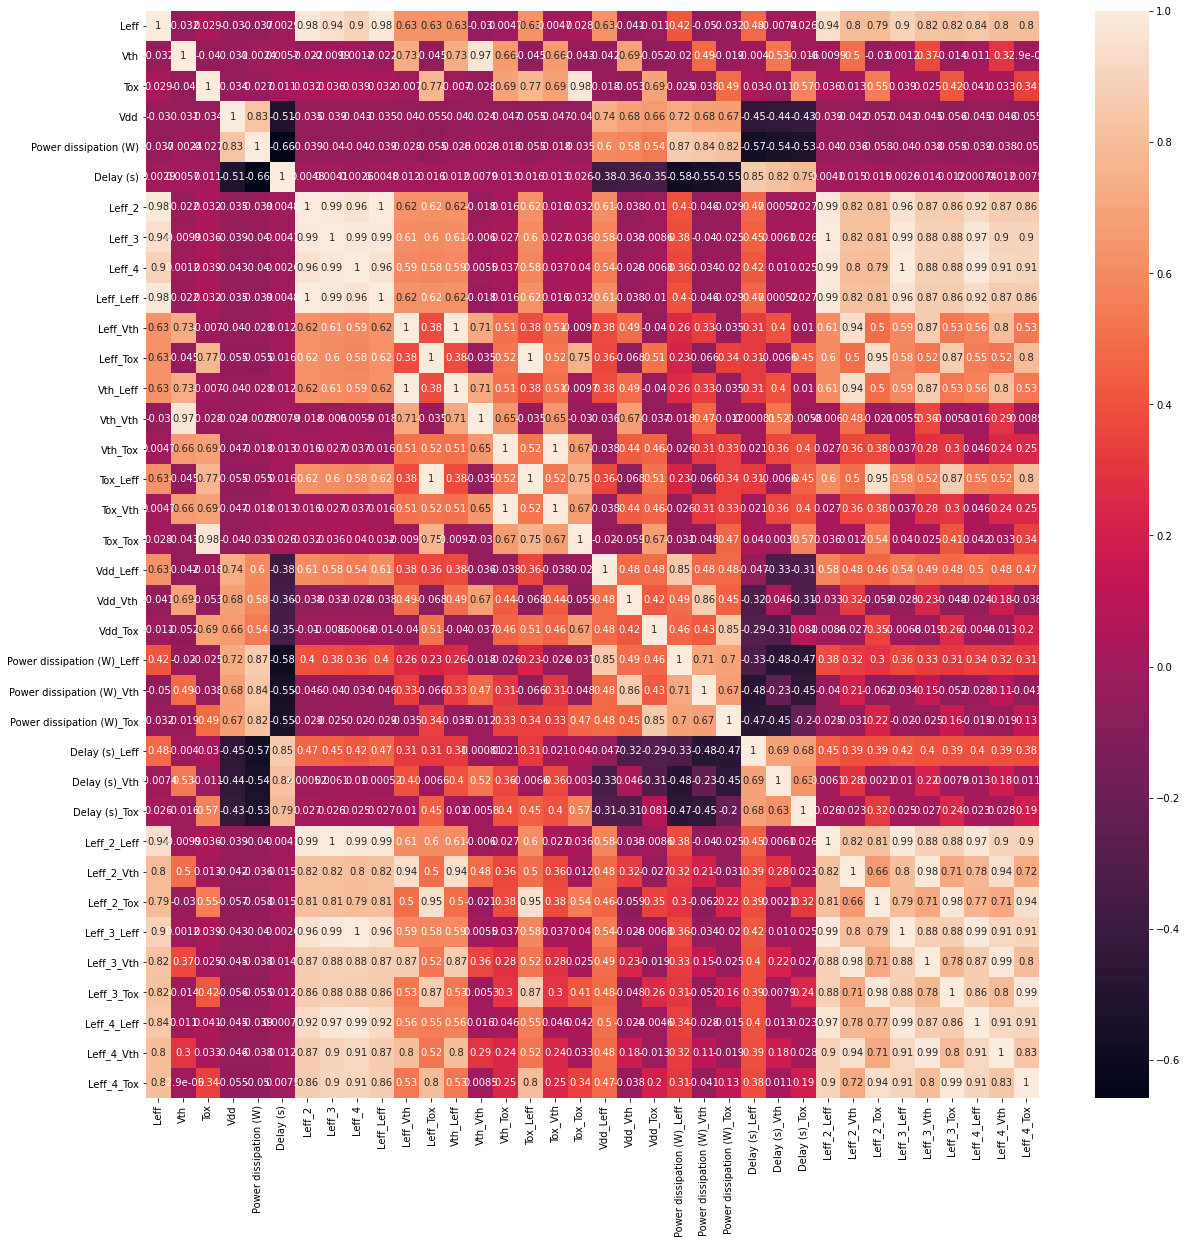

(476, 34) (477, 34) (476, 1) (477, 1)
------------------------------------
training LR using gradient descent...
r2 score is -9.530125238568763 

r2 score is -9.513951495498429 

step 0 	 dev loss: 64.86254998610781 	 train loss: 70.23560265349106
------------------------------
Dev:
r2 score is 0.6486908427976605 

Train:
r2 score is 0.6271403055983087 

step 500 	 dev loss: 0.04108579637691057 	 train loss: 0.041915521928967484
------------------------------
Dev:
r2 score is 0.8260743312451945 

Train:
r2 score is 0.80600132564252 

step 1000 	 dev loss: 0.02940152451843459 	 train loss: 0.02973027594741947
------------------------------
Dev:
r2 score is 0.9213495012797368 

Train:
r2 score is 0.9097857291234157 

step 1500 	 dev loss: 0.025460338216167003 	 train loss: 0.025596201032036577
------------------------------
Dev:
r2 score is 0.9605060101242666 

Train:
r2 score is 0.9557463909367865 

step 2000 	 dev loss: 0.024093460423565305 	 train loss: 0.024139513712819114
----------

<Figure size 432x288 with 0 Axes>

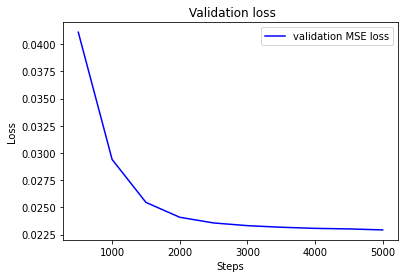

In [28]:
if __name__ == '__main__':
    scaler = Scaler() #use of scaler is optional
    #train_features, train_targets = get_features('data/train.csv',True,scaler), get_targets('data/train.csv')
    #dev_features, dev_targets = get_features('data/dev.csv',False,scaler), get_targets('data/dev.csv')
    train_features, dev_features, train_targets, dev_targets = get_features('data.csv',True,scaler)

    train_features, dev_features, train_targets, dev_targets = train_features.to_numpy(), dev_features.to_numpy(), train_targets.to_numpy(), dev_targets.to_numpy()
    
    train_targets = train_targets.reshape((train_targets.shape[0], 1))
    dev_targets = dev_targets.reshape((dev_targets.shape[0], 1))
    
    print(train_features.shape, dev_features.shape, train_targets.shape, dev_targets.shape)


    '''a_solution = analytical_solution(train_features, train_targets, C=1)
    print('evaluating analytical_solution...')
    dev_loss=do_evaluation(dev_features, dev_targets, a_solution)
    train_loss= do_evaluation(train_features, train_targets, a_solution)
    print('analytical_solution \t train loss: {}, dev_loss: {} '.format(train_loss, dev_loss))
    print(a_solution)

    #plot_trainsize_losses(train_features, train_targets,dev_features ,dev_targets)
    plot_error_historgam(dev_features, a_solution, dev_targets)'''

    print('------------------------------------')
    print('training LR using gradient descent...')
    gradient_descent_soln = do_gradient_descent(train_features, 
                         train_targets, 
                         dev_features,
                         dev_targets,
                         0.001,
                         0.01,
                         batch_size=64,
                         max_steps=5000,
                         eval_steps=500)

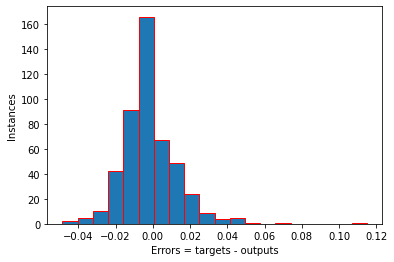

In [29]:
plot_error_historgam(dev_features, gradient_descent_soln, dev_targets)

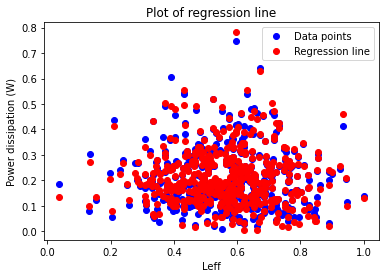

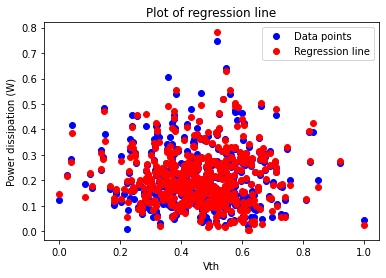

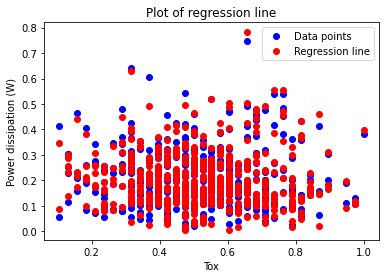

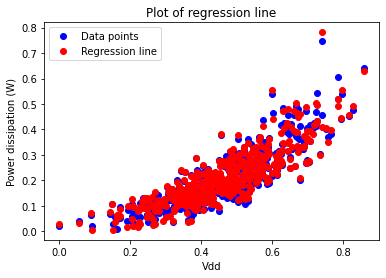

In [30]:
plot_regression_Leff(dev_features, gradient_descent_soln, dev_targets)
plot_regression_Vth(dev_features, gradient_descent_soln, dev_targets)
plot_regression_Tox(dev_features, gradient_descent_soln, dev_targets)
plot_regression_Vdd(dev_features, gradient_descent_soln, dev_targets)